In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import torch, torchvision

import data
import model

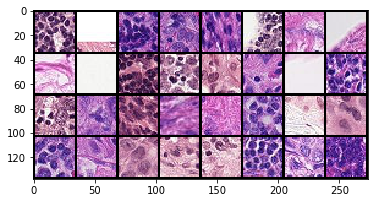

In [8]:
def softmax(x):
    return np.exp(x[:, 1]) / np.sum(np.exp(x), axis=1)

def evaluation(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

def run_model(model, testloader):
    predictions = []
    result_labels = []
    for images, labels in tqdm(testloader):
        outputs = model(images)
        predictions += list(softmax(outputs.data.numpy()))
        result_labels += list(labels)
    predictions = np.array(predictions)
    return predictions, result_labels

def validate(model):
    result = defaultdict(int)
    for images, labels in tqdm(data.valid_loader):
        outputs = model(images)
        predictions = (outputs[:, 0] < outputs[:, 1]).data.numpy()
        labels = labels.data.numpy().astype(bool)
        result['tp'] += np.sum(labels & predictions)
        result['fp'] += np.sum(np.logical_not(labels) & predictions)
        result['tn'] += np.sum(np.logical_not(labels) & np.logical_not(predictions))
        result['fn'] += np.sum(labels & np.logical_not(predictions))
    return result

def accuracy(results):
    return (results['tp'] + results['tn']) / (results['tp'] + results['fp'] + results['tn'] +results['fn'] )

images, labels = iter(data.valid_loader).next()
imshow(torchvision.utils.make_grid(images))

In [9]:
standard_model = model.Standard(load_from='./model/standard.pth')
results = validate(standard_model)
print(accuracy(results))
evaluation(standard_model, data.valid_loader)


0.79296875
Accuracy of the network on the 10000 test images: 79 %


In [10]:
equivariant_model = model.Equivariant(load_from='./model/equivariant.pth')
results = validate(equivariant_model)
print(accuracy(results))
evaluation(equivariant_model, data.valid_loader)


0.796875
Accuracy of the network on the 10000 test images: 79 %


In [11]:
labels, probs = run_model(standard_model, data.valid_loader)
labels.shape

(256,)

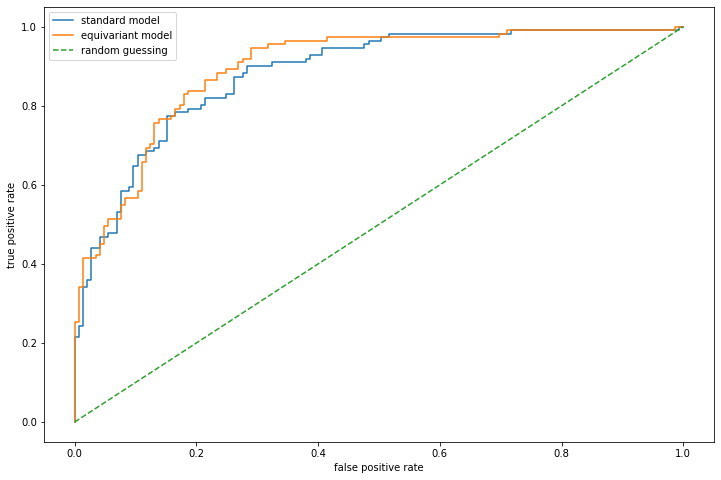

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc(probs, labels, title):
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=title)

plt.figure(figsize=(12, 8))
plot_roc(*run_model(standard_model, data.valid_loader),'standard model')
plot_roc(*run_model(equivariant_model, data.valid_loader), 'equivariant model')
plt.plot([0, 1], label='random guessing', linestyle='dashed')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

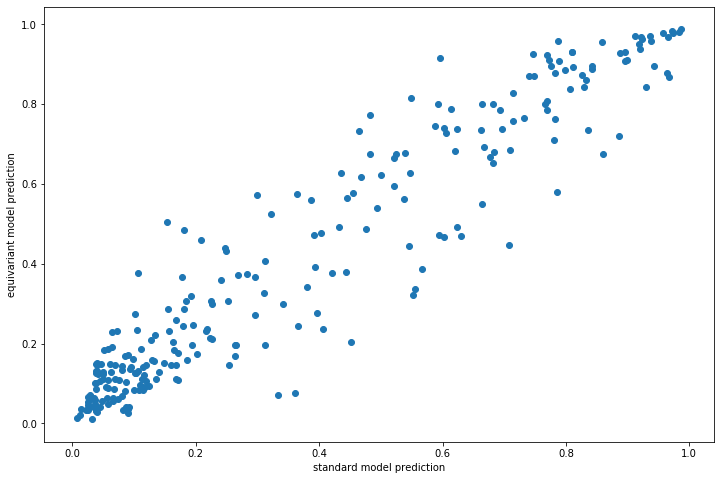

In [13]:
standard_predictions = run_model(standard_model, data.valid_loader)[0]
equivariant_predictions = run_model(equivariant_model, data.valid_loader)[0]

plt.figure(figsize=(12, 8))
plt.xlabel('standard model prediction')
plt.ylabel('equivariant model prediction')
plt.scatter(standard_predictions, equivariant_predictions)
plt.show()

In [20]:
standard_predictions = np.round(standard_predictions).astype(int)
equivariant_predictions = np.round(equivariant_predictions).astype(int)

In [31]:
# p-test

from scipy.stats import binom


wins_standard = sum((standard_predictions == 1) & (equivariant_predictions == 0)) #how often the standard model won
wins_equivariant = sum((standard_predictions == 0) & (equivariant_predictions == 1)) #how often the equivariant model won
N = wins_standard + wins_equivariant #how often one coin was a winner
print('The standard_predictions won {} times, while the equivariant_predictions won {} times.'.format(wins_standard,wins_equivariant))

The standard_predictions won 9 times, while the equivariant_predictions won 14 times.


In [33]:
b = binom(N,0.5) #N=observations of inequality, p=prob of one coin being better, which is 0.5 according to your H0
p_value = 1 - b.cdf(wins_equivariant)
print('The p-value is {:.3f}'.format(p_value))

The p-value is 0.105
